# PicTex Text Detection Model

Len Huang. Given a square image of handwritten text, return its class.

### Step 1: Import Dataset

Taken from TowardsDataScience.
https://discuss.pytorch.org/t/transforming-3-channel-image-to-greyscale-1-channel/48463/5

In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

data_dir = 'datasets/our_images_final/'
def load_split_train_test(datadir, valid_size = .2):
    transform = transforms.Compose(
        [transforms.Resize((32, 32)), 
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_data = datasets.ImageFolder(datadir, transform)
    test_data = datasets.ImageFolder(datadir, transform)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)

# WE'LL NEED TO DEFINE CLASSES FOR LATER
classes = trainloader.dataset.classes
print("Classes are:")
print(classes)
print("Train loader is:")
print(trainloader)
print("Test loader is:")
print(testloader)

Classes are:
['(', ')', '+', ',', '=', 'a', 'ast', 'b', 'c', 'cong', 'd', 'e', 'f', 'full_stop', 'g', 'geq', 'h', 'i', 'iff', 'implies', 'j', 'k', 'l', 'leq', 'm', 'minus', 'n', 'neq', 'o', 'p', 'plus', 'q', 'r', 's', 'sum', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train loader is:
Test loader is:


### Step 1.5? Image Augmentation

In [2]:
# TODO: Image augmentation

### Step 2: Create CNN

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init the class 
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=42, bias=True)
)


### Step 3: Loss Function and Optimizer

Adam/SGD and Cross Entrop Loss

In [6]:
import torch.optim as optim

# set parameters
learning_rate = 0.001
momentum = 0.9

def loss_optim():
    criterion = nn.CrossEntropyLoss()
    # Adam
    # optimizer = optim.Adam(model.parameters(), learning_rate)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Step 4: Train Model

=======================================BEGIN TRAINING=======================================
|  [Epoch: 1, Batch: 10]   Train loss: 3.657  |  Test loss: 3.660  |  Test accuracy: 0.047  |
|  [Epoch: 1, Batch: 20]   Train loss: 3.667  |  Test loss: 3.700  |  Test accuracy: 0.016  |
|  [Epoch: 1, Batch: 30]   Train loss: 3.666  |  Test loss: 3.663  |  Test accuracy: 0.078  |
|  [Epoch: 1, Batch: 40]   Train loss: 3.664  |  Test loss: 3.664  |  Test accuracy: 0.047  |
|  [Epoch: 1, Batch: 50]   Train loss: 3.652  |  Test loss: 3.633  |  Test accuracy: 0.078  |
|  [Epoch: 2, Batch: 10]   Train loss: 6.909  |  Test loss: 3.617  |  Test accuracy: 0.047  |
|  [Epoch: 2, Batch: 20]   Train loss: 3.634  |  Test loss: 3.636  |  Test accuracy: 0.047  |
|  [Epoch: 2, Batch: 30]   Train loss: 3.622  |  Test loss: 3.613  |  Test accuracy: 0.016  |
|  [Epoch: 2, Batch: 40]   Train loss: 3.618  |  Test loss: 3.642  |  Test accuracy: 0.016  |
|  [Epoch: 2, Batch: 50]   Train loss: 3.628  |  Test loss: 3

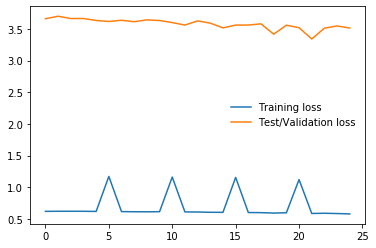

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def train_network():
    
    # Choose parameters
    num_epoch = 5
    mini_batch = 10
    train_losses, test_losses = [], []
    running_loss = 0
    
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch - 1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        # GPU Optimization
                        # inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/mini_batch:.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictex_text_detect.pth'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses

def visualize_train(train_losses, test_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test/Validation loss')
    plt.legend(frameon=False)
    plt.show()

print("=======================================BEGIN TRAINING=======================================")
train_losses, test_losses = train_network()
print("========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)

### Step 5: Test the Network

https://stackoverflow.com/questions/13214809/pretty-print-2d-python-list

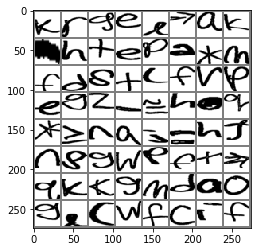

k      	r      	g      	e      	l      	implies	a    	k    
r      	g      	e      	l      	implies	a      	k    	minus
g      	e      	l      	implies	a      	k      	minus	h    
e      	l      	implies	a      	k      	minus  	h    	+    
l      	implies	a      	k      	minus  	h      	+    	e    
implies	a      	k      	minus  	h      	+      	e    	p    
a      	k      	minus  	h      	+      	e      	p    	a    
k      	minus  	h      	+      	e      	p      	a    	ast  


In [10]:
import torchvision.utils as tvu


# Function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # numpy-ify image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display Content in 8 rows 8 cols matrix
def display_class(labels):
    results = []
    for i in range(8):
        row = []
        for j in range(8):
            index = i + 1 * j
            prediction = classes[labels[index]]
            row.append(prediction)
        results.append(row)
    # Fancy code I found on StackOverflow
    s = [[str(e) for e in row] for row in results]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
        

def test_data():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(tvu.make_grid(images))
    display_class(labels)

test_data()